In [11]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from helper_plot import hdr_plot_style
hdr_plot_style()
from torch.utils.tensorboard import SummaryWriter

## Dataset MNIST

In [12]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 0     # Loading the dataset is using 4 CPU threads
batch_size  = 64   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The train set contains 48000 images, in 750 batches
The validation set contains 12000 images, in 188 batches
The test set contains 10000 images, in 157 batches


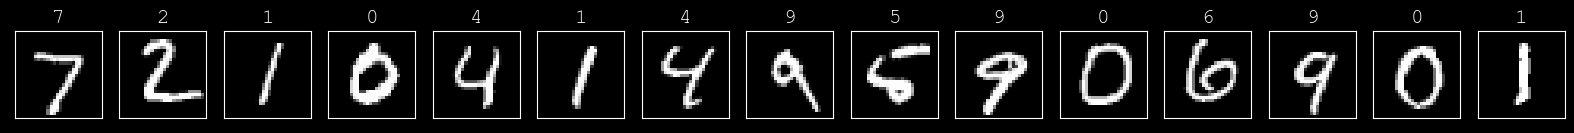

In [13]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 15
classes_names = ['0','1', '2', '3', '4', '5', '6','7', '8', '9']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def save_model(model,path):
    """ 
    Inputs : 
    path : str
        Path and name of the model you want to save
    """
    choice = input("Do you want to save your model ?")
    if choice == "Yes":
        torch.save(model.state_dict(), path)
    print(f"Model save as {path}")

import os
def load_model(var_name,path_name):
    """ 
    Inputs : 
    var_name : str
        Name under witch you want to load the model

    path_name : str
        Name of the file you want to load

    Return :
    var_name : model 
    """
    if os.path.isfile(path_name):
        var_name.load_state_dict(torch.load(path_name))
    else :
        print("File not found")


## VAE CONV

In [16]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [17]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))
        self.log_sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        self.lindec = nn.Sequential(nn.Linear(self.latent_dims,self.encoding_dims),nn.ReLU())
        
        
    def encode(self, x):
        
        x = self.encoder(x)
        mu = self.mu(x)
        log_sigma = self.log_sigma(x)
        
        return mu, log_sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(z_params)
        #print(z_tilde.shape)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, z_params):
        
        mu, log_sigma = z_params
        std = torch.exp(log_sigma)
        eps = torch.rand_like(std)
        z = mu + eps * std
        z = self.lindec(z)

        
        kl_div = 0.5 * (1 + log_sigma - mu**2 - torch.exp(log_sigma))
        kl_div = torch.sum(kl_div)  #,dim=-1
        

        return z, kl_div

--- 
La structure du VAE est donc en place, il nous reste à implémenter l'encodeur et le décodeur de notre algo

In [18]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [19]:
def construct_encoder_decoder(nin, encoding_dims = 16,n_hidden = 128,  n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
            nn.Conv2d(nin, 8, 3, stride=2, padding=1),
            nn.ReLU(True),

            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),

            nn.Flatten(1),

            nn.Linear(3 * 3 * 32, n_hidden),
            nn.ReLU(True),

            nn.Linear(n_hidden, encoding_dims)
        )

    # Decoder network
    decoder = nn.Sequential(

            nn.Linear(encoding_dims, n_hidden),
            nn.ReLU(True),

            nn.Linear(n_hidden, 3 * 3 * 32),
            nn.ReLU(True),

            #Reshape((32, 3, 3,)),
            nn.Unflatten(1,(32, 3, 3)),

            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0), 
            #nn.BatchNorm2d(16), 
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), 
            #nn.BatchNorm2d(8),
            nn.ReLU(True),

            nn.ConvTranspose2d(8, nin, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
            #nn.Tanh()
        )
    return encoder, decoder

In [20]:
# Reconstruction criterion
recons_criterion = torch.nn.BCELoss(reduction='sum').to(device)

def compute_loss(model, x):

    beta = 0.1
    y_pred,kl_div = model(x)
    full_loss = recons_criterion(y_pred, x) - kl_div*beta
    
    return full_loss

def train_step(model, x, optimizer):
    model = model.to(device)
    x = x.to(device)
    # Compute the loss.
    loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

The `FashionMNIST` dataset is composed of simple 28x28 black and white images of different items of clothings (such as shoes, bags, pants and shirts). We put a simple function here to display one batch of the test set (note that we keep a fixed batch from the test set in order to evaluate the different variations that we will try in this tutorial).

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [21]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 128
encoding_dims = 64
latent_dims = 32
# Compute input dimensionality
nin = 1
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin,encoding_dims,n_hidden,n_classes=num_classes)
encoder = encoder.to(device)
decoder = decoder.to(device)
# Build the VAE model
model = VAE(encoder, decoder, encoding_dims, latent_dims).to(device)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

In [22]:
checkpoint = 'MNIST_CONV_BCE_sum_Beta=0.1'
writer = SummaryWriter('runs/' + checkpoint)

In [23]:
def train_vae(model,epochs,test_sample):
    test_sample = test_sample.to(device)
    model=model.to(device)
    for epoch in range(1, epochs + 1):
        full_loss = torch.Tensor([0]).to(device)
        # Forward pass: compute predicted y by passing x to the model.
        for i, (x, _) in enumerate(train_loader):
            x=x.to(device)
            model=model.to(device)
            full_loss += train_step(model, x, optimizer)


        writer.add_scalar("Loss/Full_Loss", full_loss.cpu().detach().numpy(),epoch)   

        if epoch%5==0:
            predictions, _ = model(test_sample)
            fig = plt.figure(figsize=(4, 4))
            for i in range(predictions.shape[0]):
                plt.subplot(4, 4, i + 1)
                plt.imshow(predictions[i, 0, :, :].detach().cpu().numpy(), cmap='gray')
                plt.axis('off')

            plt.show()
            writer.add_figure("Image/Test_Visu", fig,epoch) 
        writer.flush()




        print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))

Epoch: 1, Test set ELBO: tensor([16161699.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2, Test set ELBO: tensor([9743418.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3, Test set ELBO: tensor([9369348.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4, Test set ELBO: tensor([9015489.], device='cuda:0', grad_fn=<AddBackward0>)


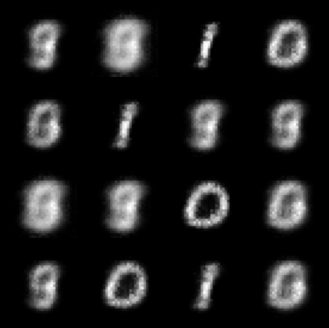

Epoch: 5, Test set ELBO: tensor([8862241.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6, Test set ELBO: tensor([8764746.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7, Test set ELBO: tensor([8671906.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8, Test set ELBO: tensor([8491573.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9, Test set ELBO: tensor([8146182.], device='cuda:0', grad_fn=<AddBackward0>)


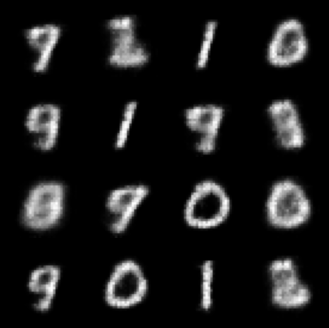

Epoch: 10, Test set ELBO: tensor([7804670.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11, Test set ELBO: tensor([7441845.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 12, Test set ELBO: tensor([7263924.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 13, Test set ELBO: tensor([7132030.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 14, Test set ELBO: tensor([6954000.], device='cuda:0', grad_fn=<AddBackward0>)


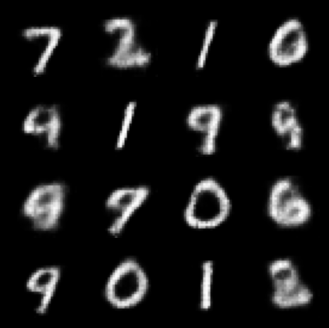

Epoch: 15, Test set ELBO: tensor([6733502.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 16, Test set ELBO: tensor([6605722.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 17, Test set ELBO: tensor([6513990.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 18, Test set ELBO: tensor([6446910.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 19, Test set ELBO: tensor([6389397.5000], device='cuda:0', grad_fn=<AddBackward0>)


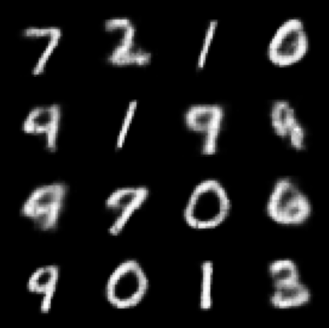

Epoch: 20, Test set ELBO: tensor([6335241.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 21, Test set ELBO: tensor([6276628.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 22, Test set ELBO: tensor([6199256.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 23, Test set ELBO: tensor([6080738.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 24, Test set ELBO: tensor([5981021.5000], device='cuda:0', grad_fn=<AddBackward0>)


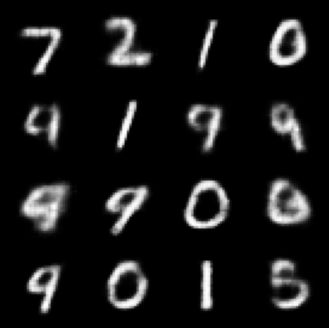

Epoch: 25, Test set ELBO: tensor([5898141.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 26, Test set ELBO: tensor([5820873.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 27, Test set ELBO: tensor([5747051.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 28, Test set ELBO: tensor([5681529.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 29, Test set ELBO: tensor([5597826.], device='cuda:0', grad_fn=<AddBackward0>)


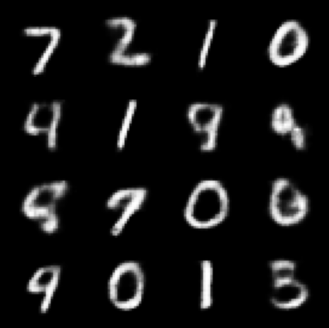

Epoch: 30, Test set ELBO: tensor([5513821.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 31, Test set ELBO: tensor([5452166.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 32, Test set ELBO: tensor([5398558.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 33, Test set ELBO: tensor([5346152.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 34, Test set ELBO: tensor([5286958.5000], device='cuda:0', grad_fn=<AddBackward0>)


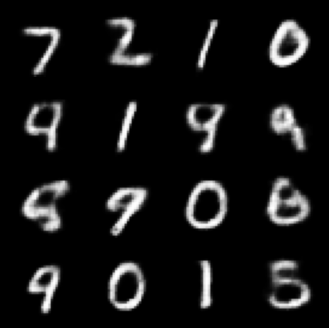

Epoch: 35, Test set ELBO: tensor([5230111.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 36, Test set ELBO: tensor([5170962.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 37, Test set ELBO: tensor([5103748.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 38, Test set ELBO: tensor([5035886.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 39, Test set ELBO: tensor([4983647.5000], device='cuda:0', grad_fn=<AddBackward0>)


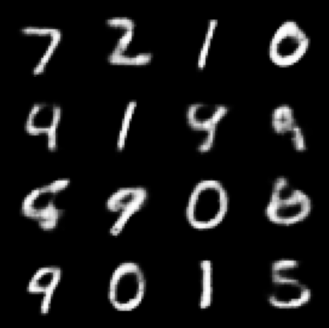

Epoch: 40, Test set ELBO: tensor([4942116.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 41, Test set ELBO: tensor([4902155.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 42, Test set ELBO: tensor([4864654.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 43, Test set ELBO: tensor([4830886.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 44, Test set ELBO: tensor([4797113.5000], device='cuda:0', grad_fn=<AddBackward0>)


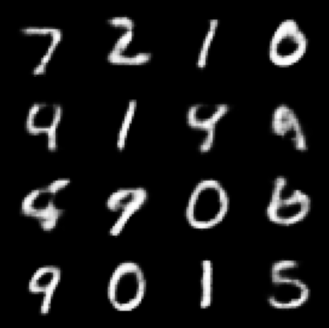

Epoch: 45, Test set ELBO: tensor([4766694.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 46, Test set ELBO: tensor([4735092.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 47, Test set ELBO: tensor([4701937.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 48, Test set ELBO: tensor([4666397.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 49, Test set ELBO: tensor([4635647.5000], device='cuda:0', grad_fn=<AddBackward0>)


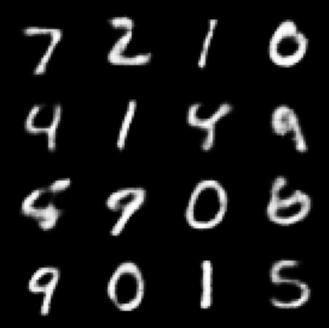

Epoch: 50, Test set ELBO: tensor([4610443.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 51, Test set ELBO: tensor([4585053.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 52, Test set ELBO: tensor([4564538.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 53, Test set ELBO: tensor([4543350.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 54, Test set ELBO: tensor([4525477.5000], device='cuda:0', grad_fn=<AddBackward0>)


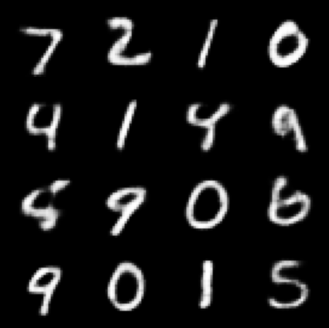

Epoch: 55, Test set ELBO: tensor([4507255.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 56, Test set ELBO: tensor([4491031.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 57, Test set ELBO: tensor([4476188.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 58, Test set ELBO: tensor([4460503.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 59, Test set ELBO: tensor([4446916.], device='cuda:0', grad_fn=<AddBackward0>)


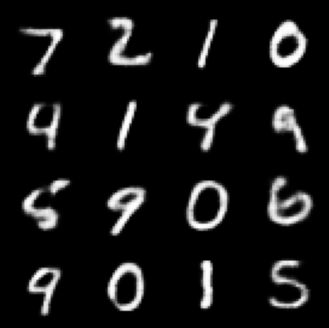

Epoch: 60, Test set ELBO: tensor([4432681.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 61, Test set ELBO: tensor([4420459.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 62, Test set ELBO: tensor([4407504.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 63, Test set ELBO: tensor([4396176.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 64, Test set ELBO: tensor([4386015.5000], device='cuda:0', grad_fn=<AddBackward0>)


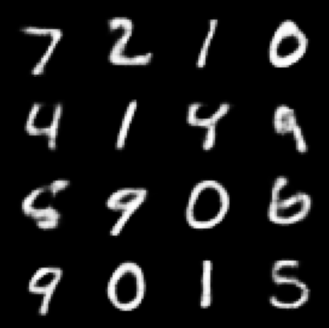

Epoch: 65, Test set ELBO: tensor([4374236.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 66, Test set ELBO: tensor([4365805.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 67, Test set ELBO: tensor([4356079.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 68, Test set ELBO: tensor([4343708.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 69, Test set ELBO: tensor([4335764.5000], device='cuda:0', grad_fn=<AddBackward0>)


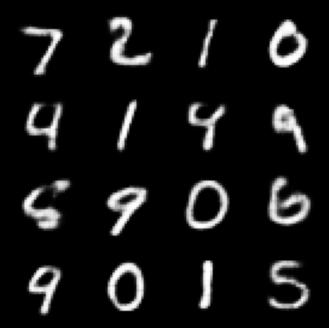

Epoch: 70, Test set ELBO: tensor([4325914.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 71, Test set ELBO: tensor([4318145.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 72, Test set ELBO: tensor([4308551.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 73, Test set ELBO: tensor([4299080.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 74, Test set ELBO: tensor([4290548.], device='cuda:0', grad_fn=<AddBackward0>)


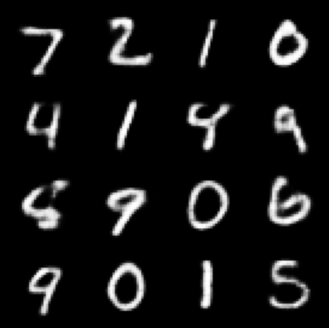

Epoch: 75, Test set ELBO: tensor([4281957.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 76, Test set ELBO: tensor([4273843.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 77, Test set ELBO: tensor([4264798.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 78, Test set ELBO: tensor([4255791.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 79, Test set ELBO: tensor([4247522.5000], device='cuda:0', grad_fn=<AddBackward0>)


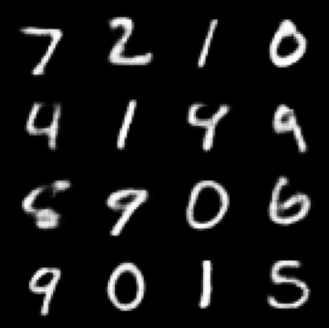

Epoch: 80, Test set ELBO: tensor([4236093.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 81, Test set ELBO: tensor([4227393.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 82, Test set ELBO: tensor([4214433.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 83, Test set ELBO: tensor([4204771.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 84, Test set ELBO: tensor([4194276.5000], device='cuda:0', grad_fn=<AddBackward0>)


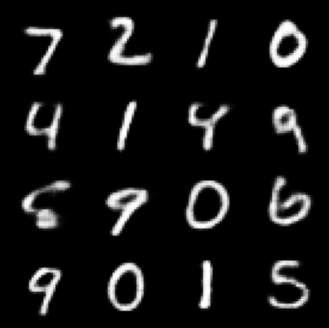

Epoch: 85, Test set ELBO: tensor([4180782.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 86, Test set ELBO: tensor([4169825.], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 87, Test set ELBO: tensor([4157294.2500], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 88, Test set ELBO: tensor([4145088.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 89, Test set ELBO: tensor([4133329.2500], device='cuda:0', grad_fn=<AddBackward0>)


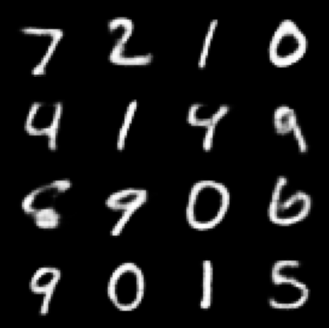

Epoch: 90, Test set ELBO: tensor([4124011.7500], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 91, Test set ELBO: tensor([4113436.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 92, Test set ELBO: tensor([4101836.2500], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 93, Test set ELBO: tensor([4092506.5000], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 94, Test set ELBO: tensor([4083310.7500], device='cuda:0', grad_fn=<AddBackward0>)


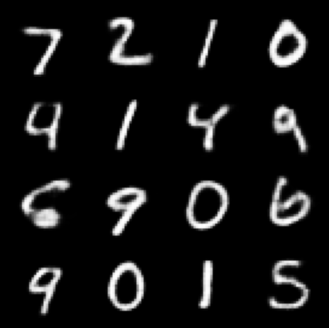

Epoch: 95, Test set ELBO: tensor([4075754.7500], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 96, Test set ELBO: tensor([4065632.7500], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 97, Test set ELBO: tensor([4057024.7500], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 98, Test set ELBO: tensor([4048043.7500], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 99, Test set ELBO: tensor([4040359.5000], device='cuda:0', grad_fn=<AddBackward0>)


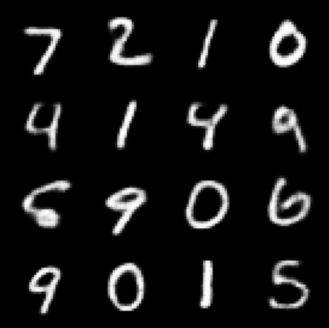

Epoch: 100, Test set ELBO: tensor([4032126.7500], device='cuda:0', grad_fn=<AddBackward0>)


In [24]:
epochs=100
test_sample = imgs_test[0:16, :, :, :]
train_vae(model, epochs,test_sample)

In [28]:
save_model(model,"./Models/MNIST_CONV_BCE.pth")

Model save as ./Models/MNIST_CONV_BCE.pth


We can also evaluate the latent space of our model, which should be organized (being the overall point of using a VAE instead of a common AE).

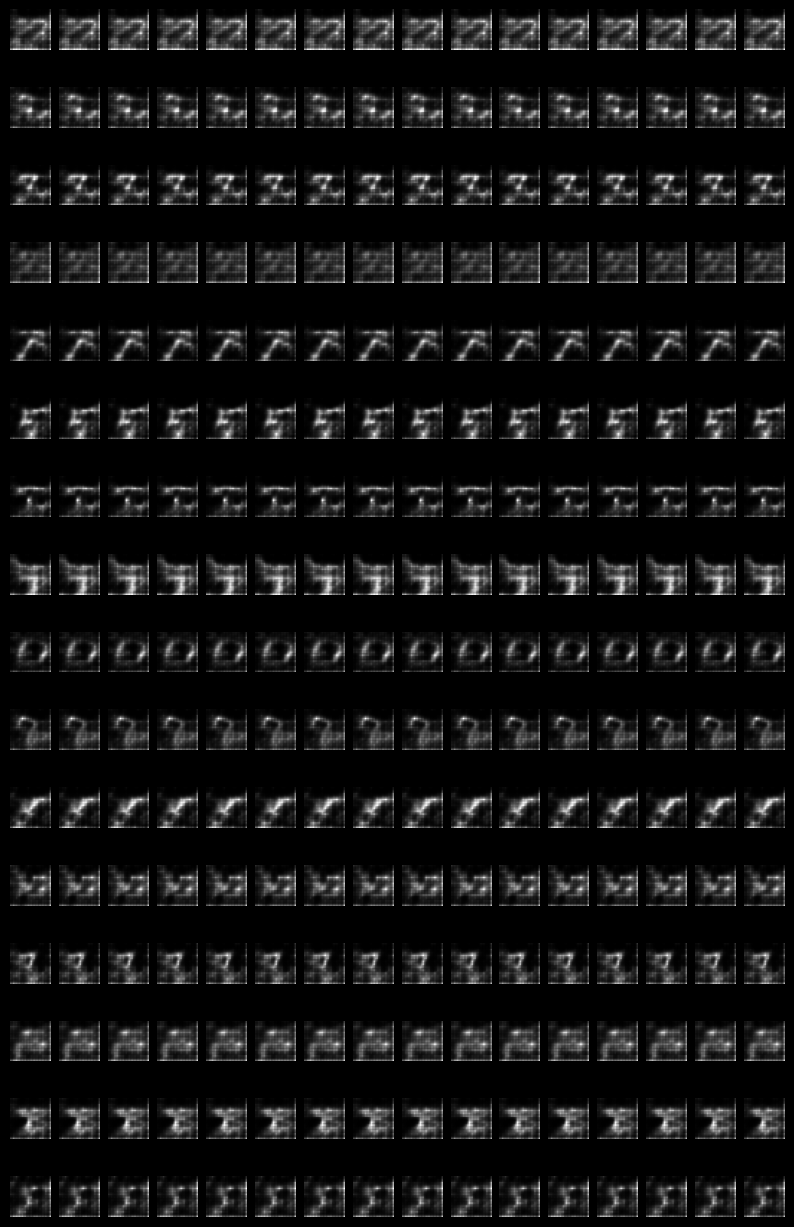

In [26]:
nb_image = 16

final_tensor = torch.randn(nb_image,64)
fig = plt.figure(figsize=(10, nb_image))
for i in range(nb_image):
    for j in range(nb_image):
        plt.subplot(nb_image, nb_image, (i * nb_image) + j + 1)

        plt.imshow(model.decode(final_tensor.to(device)).cpu().detach()[i].reshape(28, 28), cmap='gray')
        plt.axis('off')